# Fit using log zeta generilize

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 \left(\frac{1}{series(n_v,p,z=a_3,a=a_2)}\right) $$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 



In [16]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    a1,a2,a3 = coefs
    return a1*(1/serie_divergente(1/x,p,z=a3,a=a2))


def get_extrapol_function(model_function, coefs, ):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [25]:
def residuals_func(coefs,x,fi,fi_err=None):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns a value with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    Args:
        coefs: Tuple: Parameters to be adjusted of the model
        x: float: Independent variable
        fi: float: Experimental value to adjust, also call y_i
        fi_err: Error for the experimental value, also call y_err_i
    Returns:
        residuals: float: Difference of the model evaluation and expected value
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    if fi_err is not None:
        residuals = fi - model_function(
            x,
            coefs
        ) / fi_err
        
        return residuals
    else:
        residuals = fi - model_function(
            x,
            coefs
        )
        
        return residuals


def get_residuals_func_sum_sqr(x_data,y_data,y_data_err=None):
    def residuals_func_sum_sqr(coefs):
        """Calculate the sum of the squared residuals."""
        result = 0
        num_el = len(x_data)
        for index in range(num_el):
            if y_data_err is not None:
                result = result + residuals_func(coefs,x_data[index],y_data[index],y_data_err[index])**2
            else:
                result = result + residuals_func(coefs,x_data[index],y_data[index])**2
        return result

    return residuals_func_sum_sqr

## Read files

In [18]:
# get inv_temp
data_path = Path("../../data/regular/infinite-size").resolve()
file = 'regular_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))
# get uncert inv_temp
file_err = 'regular_all_inv_Tc_uncertainty.csv'
df_all_tc_err = pd.read_csv(os.path.join(data_path,file_err))

In [19]:
df_params = pd.DataFrame(index=["a1","a2","a3","a1_er","a2_er","a3_er"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

      fun: 0.005422672783548568
 hess_inv: array([[ 17.67831886, -60.27929515,   2.52327323],
       [-60.27929515, 208.13419144,  -8.45535549],
       [  2.52327323,  -8.45535549,   0.388822  ]])
      jac: array([ 3.84700252e-06,  8.41449946e-07, -5.09381061e-06])
  message: 'Optimization terminated successfully.'
     nfev: 115
      nit: 17
     njev: 23
   status: 0
  success: True
        x: array([0.634375  , 1.75929511, 1.02483014])


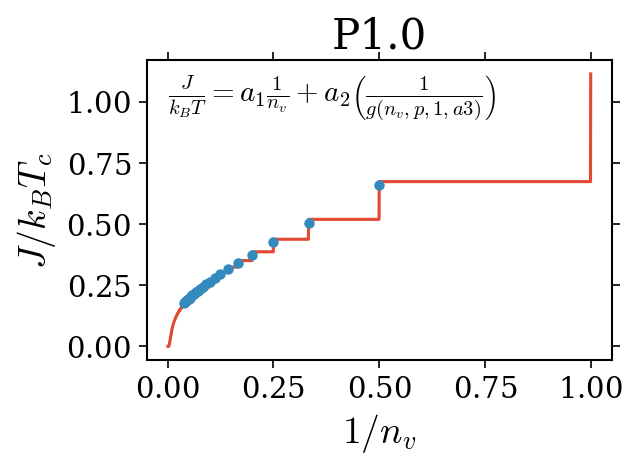

---------------------------------------------
params: [0.634375   1.75929511 1.02483014]
---------------------------------------------
min:3.3656053328728845e-10 at 0.001


[ 17.67831886 -60.27929515   2.52327323]
[-60.27929515 208.13419144  -8.45535549]
[ 2.52327323 -8.45535549  0.388822  ]
Uncertainty: [0.04204559294771622, 0.14426856602783428, 0.00623555932950736]


In [29]:
epsilon = 0.0001
tol = 0.0001 # tolerance by minimize 
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_inv_zeta_gen_3_parms_witherr'
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    y_data_err = df_all_tc_err[COLUMN].dropna().values
#     # add value at nv=1
#     x_data = np.concatenate([x_data,[1]])
#     y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0)
#         y_data = np.insert(y_data,0,0)
        
    # fit 
#     funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err)
    funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
    best_fit_result = minimize(funct_to_min, x0=(1, 1, 1),tol=tol)
    print(best_fit_result)

    extrapol_funct = get_extrapol_function(model_function, best_fit_result.x)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1, 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1 \frac{1}{n_v} + a_2 \left(\frac{1}{g(n_v,p,1,a3)}\right)$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("params: {}".format(best_fit_result.x))
    print("---------------------------------------------")
    df_extrapol_val[COLUMN] = [extrapol_funct(0+epsilon),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")
    
    # For errors
    uncertainty = []
    tmp_i = np.zeros(len(best_fit_result.x))
    for i in range(len(best_fit_result.x)):
        tmp_i[i] = 1.0
        hess_inv = np.dot(best_fit_result.hess_inv,tmp_i)
        print(hess_inv)
        uncertainty.append(np.sqrt(max(1, abs(best_fit_result.fun)) * tol * hess_inv[i]))
        tmp_i[i] = 0
    print('Uncertainty: {}'.format(uncertainty))
        
    df_params[COLUMN] = [*best_fit_result.x,*uncertainty]

        
    break


In [20]:
df_extrapol_val["P2.0"]['infty']

0.5608535941793719

In [17]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [15]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms'

In [18]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
a1  0.475182  0.470120  0.464363  0.460189  0.456606  0.454045  0.452435   
a2  2.511984  2.333799  2.197470  2.083652  1.988467  1.905841  1.834061   

        P1.7      P1.8      P1.9      P2.0  
a1  0.452568  0.453964  0.456338  0.459997  
a2  1.768204  1.708750  1.655520  1.606323  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_params_curves.csv
           P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty  0.000000  0.050016  0.103578  0.159431  0.216220  0.273057  0.329248   
1      1.193649  1.194205  1.194441  1.195113  1.195273  1.194617  1.194037   

           P1.7      P1.8      P1.9      P2.0  
infty  0.384394  0.437917  0.489453  0.538634  
1      1.192583  1.190812  1.189219  1.186917  
Exporting to csv files the extrapolation val

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_2_parms_all_p.png


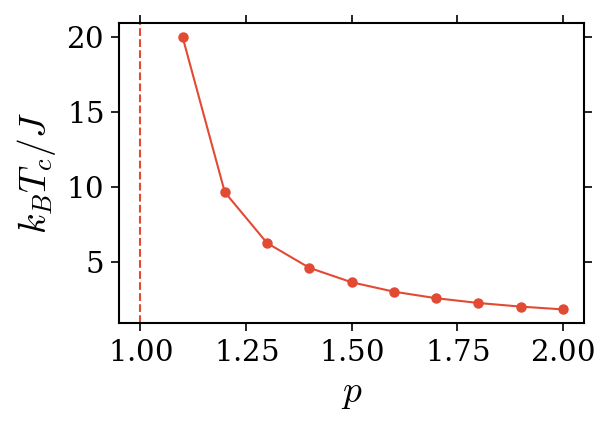

In [19]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()